In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
import tensorflow as tf

In [ ]:
bbox_data = pd.read_csv('/Users/vivekreddypalsani/Documents/mahindra/mahindra-3rd/3rd-fall/DIP/project/Dataset/train/Train_data/Cropped_data/csv/combined_samples.csv')  # Replace with your CSV file path
IMG_SIZE = (224, 224)

In [ ]:
def preprocess_image_with_bbox(row):
    img_path = row['image_path']
    img = cv2.imread(img_path)
    original_height, original_width = img.shape[:2]

    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0 

    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    x = (x / original_width) * IMG_SIZE[0]
    y = (y / original_height) * IMG_SIZE[1]
    w = (w / original_width) * IMG_SIZE[0]
    h = (h / original_height) * IMG_SIZE[1]

    return img, [x, y, w, h]

In [ ]:
images = []
bboxes = []
for _, row in bbox_data.iterrows():
    img, bbox = preprocess_image_with_bbox(row)
    images.append(img)
    bboxes.append(bbox)

images = np.array(images)
bboxes = np.array(bboxes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, bboxes, test_size=0.2, random_state=42)

In [ ]:
def display_sample_images(X, y, title):
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        img = X[i]
        x, y_coord, w, h = y[i]
        plt.imshow(img)
        plt.gca().add_patch(
            plt.Rectangle((x, y_coord), w, h, fill=False, edgecolor='red', linewidth=2)
        )
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [ ]:
display_sample_images(X_train, y_train, "Sample Images with Bounding Boxes (Training Data)")

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(4, activation='linear')(x)  

In [ ]:
model = Model(inputs, x)

for layer in base_model.layers[-10:]: 
    layer.trainable = True

def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    condition = tf.less(diff, 1.0)
    small = 0.5 * tf.square(diff)
    large = diff - 0.5
    return tf.where(condition, small, large)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=smooth_l1_loss, metrics=['mae'])
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch + 1}: Loss = {logs['loss']:.4f}, Validation Loss = {logs['val_loss']:.4f}")

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    verbose=1,
    callbacks=[CustomCallback(), lr_scheduler]
)

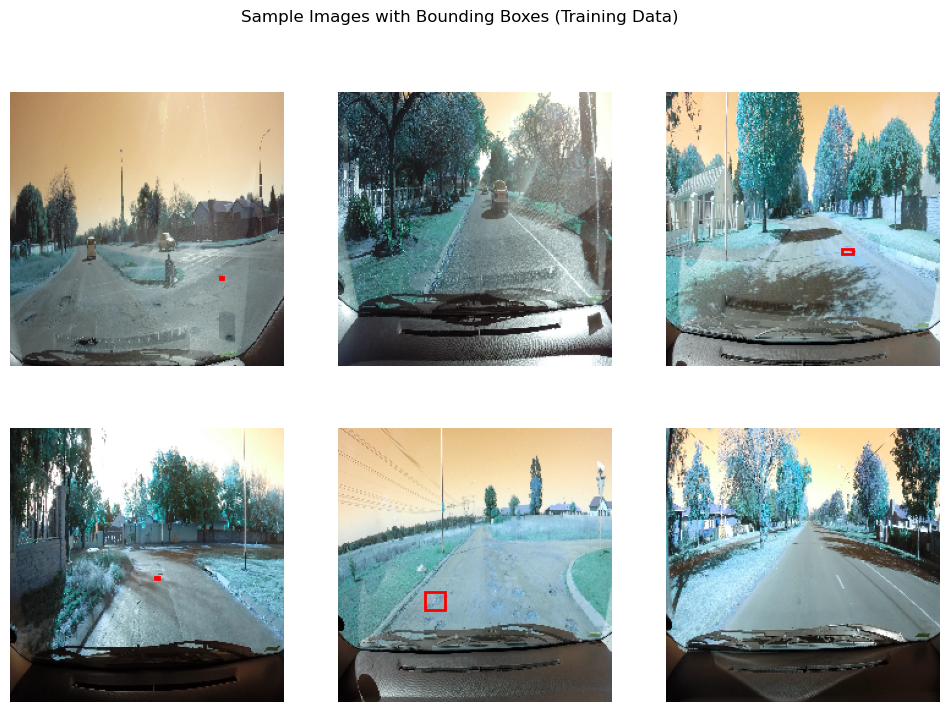

Epoch 1/40
164/164 [==============================] - 60s 353ms/step - loss: 37.1669 - mae: 37.6455 - val_loss: 35.6844 - val_mae: 36.1614 - lr: 1.0000e-04
Epoch 2/40
164/164 [==============================] - 49s 298ms/step - loss: 32.1706 - mae: 32.6385 - val_loss: 29.8669 - val_mae: 30.3343 - lr: 1.0000e-04
Epoch 3/40
164/164 [==============================] - 48s 294ms/step - loss: 27.8970 - mae: 28.3619 - val_loss: 26.3903 - val_mae: 26.8572 - lr: 1.0000e-04
Epoch 4/40
164/164 [==============================] - 49s 298ms/step - loss: 24.9233 - mae: 25.3869 - val_loss: 23.7300 - val_mae: 24.1947 - lr: 1.0000e-04
Epoch 5/40
164/164 [==============================] - 59s 361ms/step - loss: 22.1783 - mae: 22.6401 - val_loss: 21.4225 - val_mae: 21.8897 - lr: 1.0000e-04
Epoch 6/40
164/164 [==============================] - 67s 412ms/step - loss: 20.1540 - mae: 20.6154 - val_loss: 19.8992 - val_mae: 20.3624 - lr: 1.0000e-04
Epoch 7/40
164/164 [==============================] - 57s 349ms/

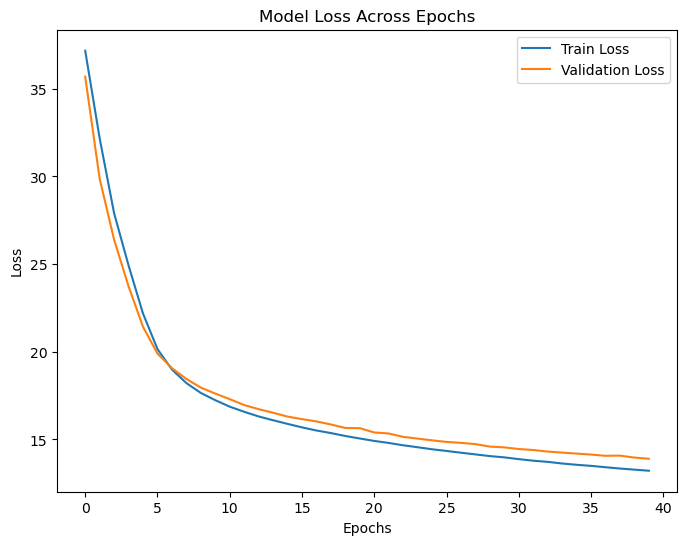

: 

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

predictions = model.predict(X_test)

threshold = 20  
correct_predictions = np.sum(np.abs(predictions - y_test) < threshold, axis=1) == 4
accuracy = np.mean(correct_predictions)

print("\nBounding Box Prediction Accuracy:")
print(f"Correct Predictions: {np.sum(correct_predictions)} / {len(y_test)}")
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Plot loss across epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 88ms/step


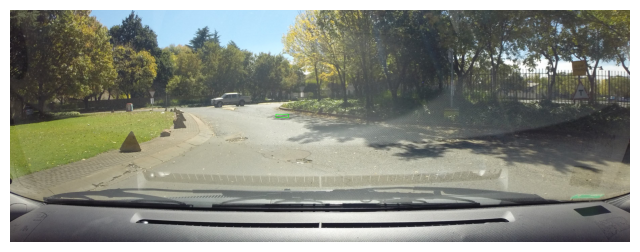

In [ ]:
IMG_SIZE = (224, 224)

def preprocess_image_for_prediction(image_path):
    img = cv2.imread(image_path)
    original_height, original_width = img.shape[:2]
    
    img_resized = cv2.resize(img, IMG_SIZE)    
    img_resized = img_resized / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)
    
    return img_resized, original_height, original_width

def plot_bounding_box(image, bbox, original_height, original_width):
    x, y, w, h = bbox
    x = int((x / IMG_SIZE[0]) * original_width)
    y = int((y / IMG_SIZE[1]) * original_height)
    w = int((w / IMG_SIZE[0]) * original_width)
    h = int((h / IMG_SIZE[1]) * original_height)
    
    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2) 
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def predict_and_display(image_path):
    img_resized, original_height, original_width = preprocess_image_for_prediction(image_path)
    
    predicted_bbox = model.predict(img_resized)
    
    predicted_bbox = predicted_bbox[0]
    image = cv2.imread(image_path)
    
    plot_bounding_box(image, predicted_bbox, original_height, original_width)

image_path = '/Users/vivekreddypalsani/Documents/mahindra/mahindra-3rd/3rd-fall/DIP/project/Dataset/train/Train_data/Cropped_data/Positive_data/G0010766.JPG'  # Replace with the path to your test image
predict_and_display(image_path)